# Artist classification using BERT
This notebook is meant to be used to test the performance of bert on different sizes of classes.

In [1]:
import os
cache_folder = '/mount/studenten-temp1/users/knupleun/.cache/huggingface'
os.environ['TRANSFORMERS_CACHE'] = cache_folder

In [2]:
import os
device_num = 5

os.environ['TRANSFORMERS_CACHE'] = '/mount/studenten-temp1/users/knupleun/.cache/huggingface'
os.environ['CUDA_VISIBLE_DEVICES'] = str(device_num)

## Pre-trained BERT on artist classification 

In [3]:
from datasets import load_dataset, ClassLabel


def get_dataset(dataset_folder, subclass_size):
   dataset = load_dataset('csv',
                        data_files={
                           'train': dataset_folder + 'songs_train.txt',
                           'test': dataset_folder + 'songs_test.txt',
                           'dev': dataset_folder + 'songs_dev.txt',
                        },
                        column_names=['artist', 'title', 'lyrics'],
                        sep='\t')

   # the last one takes it all
   if subclass_size != 643:
      set_artist = list(set(dataset['train']['artist']))[:subclass_size]
      dataset = dataset.filter(lambda x: x['artist'] in set_artist)

   union_artists = set(dataset['train']['artist']) | set(dataset['test']['artist']) | set(dataset['dev']['artist'])
   artists = ClassLabel(names=list(union_artists))

   return dataset, artists


In [4]:
from csv import writer

def write_results(filepath, values):
    with open(filepath, 'a+', newline='') as f:
        csv_writer = writer(f)
        csv_writer.writerow(values)

def write_pre_bert_results(filepath, scores, artists, dataset):
    model = "pre-bert-knn"
    class_size = artists.num_classes
    train_size = len(dataset['train'])
    test_size = len(dataset['test'])

    for n, score in enumerate(scores, start=1):
        values = [model, class_size, train_size, test_size, score, n]
        write_results(filepath, values)

In [5]:
from tqdm.notebook import tqdm
from transformers import AutoModel, AutoTokenizer
import torch

def transform(example):
    example['lyrics'] = example['lyrics'].replace(' NEWLINE ', ' [SEP] ')

    return example

def get_embeddings(model_path, artists, dataset):
    model = AutoModel.from_pretrained(model_path, output_hidden_states=True).to('cuda')
    tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

    tokenized_dataset = dataset.map(transform, load_from_cache_file=False)

    batch_size = 64
    num_shards = len(tokenized_dataset) // batch_size 
    embeddings = []
    labels = []
    for i in tqdm(range(num_shards)):
        shard = tokenized_dataset.shard(num_shards=num_shards, index=i)
        model_inputs = tokenizer(shard['lyrics'], padding=True, truncation=True, return_tensors="pt").to('cuda')

        labels.extend(artists.str2int(shard['artist']))

        # Info on getting hidden state embeddings
        # https://mccormickml.com/2019/05/14/BERT-word-embeddings-tutorial/#32-understanding-the-output
        with torch.no_grad():
            outputs = model(**model_inputs)

            hidden_states = outputs[2]

            # Getting single vector representations by averaging the second to last hiden layer of each token producing a single 768 length vector.
            token_vecs = hidden_states[-2]


            # Calculate the average of all 512 token vectors (that's the size of the input)
            # Using the second dimension, because the first representes each lyric
            sentence_embedding = torch.mean(token_vecs, dim=1)
            sentence_embedding = sentence_embedding.cpu().detach().numpy()

            embeddings.extend(sentence_embedding)


    del model
    del tokenizer 

    torch.cuda.empty_cache()
    return embeddings, labels

def run_knn_experiment(model_path, artists, dataset):
    from sklearn.neighbors import KNeighborsClassifier

    train_embeddings, train_labels = get_embeddings(model_path, artists, dataset['train'])
    test_embeddings, test_labels = get_embeddings(model_path, artists, dataset['test'])

    neigh = KNeighborsClassifier(weights="distance")
    neigh.fit(train_embeddings, train_labels)


    import matplotlib.pyplot as plt
    import evaluate

    acc_metric = evaluate.load("accuracy")

    def evalute_knn(embeddings, references):
        diff_setups = []
        for n in range(1,26):
            neigh.set_params(n_neighbors=n)
            predictions = neigh.predict(embeddings)

            diff_setups.append({'n': n, 'predictions': predictions})

        scores = []
        n_neighbours = []
        for i, setup in enumerate(diff_setups):
            metric = acc_metric.compute(predictions=setup['predictions'], references=references)

            score = metric['accuracy']
            scores.append(score)
            n_neighbours.append(i + 1)

        return n_neighbours, scores


    n_neighbours, scores = evalute_knn(test_embeddings, test_labels)

    plt.plot(n_neighbours, scores)

    print()
    print('Training examples:', len(train_embeddings))
    print('Test examples:', len(test_embeddings))
    plt.show()

    torch.cuda.empty_cache()

    return n_neighbours, scores

Using custom data configuration default-326223662ac9146d
Reusing dataset csv (/mount/studenten-temp1/users/knupi/.cache/huggingface/csv/default-326223662ac9146d/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached processed dataset at /mount/studenten-temp1/users/knupi/.cache/huggingface/csv/default-326223662ac9146d/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58/cache-90710e79e3a0a551.arrow
Loading cached processed dataset at /mount/studenten-temp1/users/knupi/.cache/huggingface/csv/default-326223662ac9146d/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58/cache-d880c89563c3f906.arrow
Loading cached processed dataset at /mount/studenten-temp1/users/knupi/.cache/huggingface/csv/default-326223662ac9146d/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58/cache-46cfeda1e9f9e71c.arrow
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform

  0%|          | 0/784 [00:00<?, ?ex/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/1 [00:00<?, ?it/s]


Training examples: 784
Test examples: 106


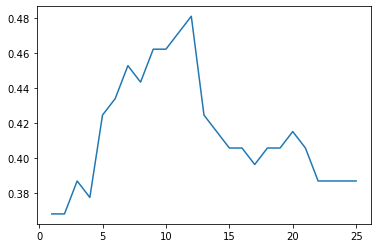

Using custom data configuration default-326223662ac9146d
Reusing dataset csv (/mount/studenten-temp1/users/knupi/.cache/huggingface/csv/default-326223662ac9146d/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58)


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?ba/s]

  0%|          | 0/6 [00:00<?, ?ba/s]

  0%|          | 0/6 [00:00<?, ?ba/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/1691 [00:00<?, ?ex/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/242 [00:00<?, ?ex/s]

  0%|          | 0/3 [00:00<?, ?it/s]


Training examples: 1691
Test examples: 242


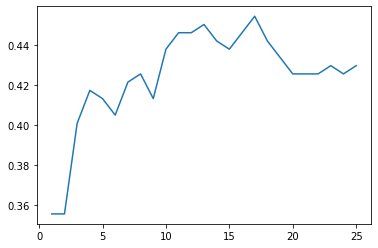

Using custom data configuration default-326223662ac9146d
Reusing dataset csv (/mount/studenten-temp1/users/knupi/.cache/huggingface/csv/default-326223662ac9146d/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58)


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?ba/s]

  0%|          | 0/6 [00:00<?, ?ba/s]

  0%|          | 0/6 [00:00<?, ?ba/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/3477 [00:00<?, ?ex/s]

  0%|          | 0/54 [00:00<?, ?it/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/476 [00:00<?, ?ex/s]

  0%|          | 0/7 [00:00<?, ?it/s]


Training examples: 3477
Test examples: 476


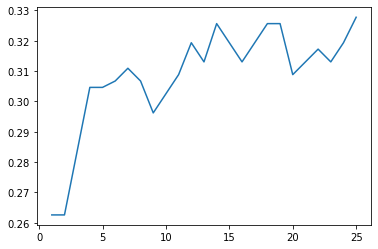

Using custom data configuration default-326223662ac9146d
Reusing dataset csv (/mount/studenten-temp1/users/knupi/.cache/huggingface/csv/default-326223662ac9146d/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58)


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?ba/s]

  0%|          | 0/6 [00:00<?, ?ba/s]

  0%|          | 0/6 [00:00<?, ?ba/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/7086 [00:00<?, ?ex/s]

  0%|          | 0/110 [00:00<?, ?it/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/902 [00:00<?, ?ex/s]

  0%|          | 0/14 [00:00<?, ?it/s]


Training examples: 7086
Test examples: 902


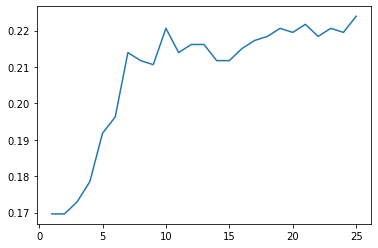

Using custom data configuration default-326223662ac9146d
Reusing dataset csv (/mount/studenten-temp1/users/knupi/.cache/huggingface/csv/default-326223662ac9146d/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58)


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?ba/s]

  0%|          | 0/6 [00:00<?, ?ba/s]

  0%|          | 0/6 [00:00<?, ?ba/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/14566 [00:00<?, ?ex/s]

  0%|          | 0/227 [00:00<?, ?it/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/1817 [00:00<?, ?ex/s]

  0%|          | 0/28 [00:00<?, ?it/s]


Training examples: 14566
Test examples: 1817


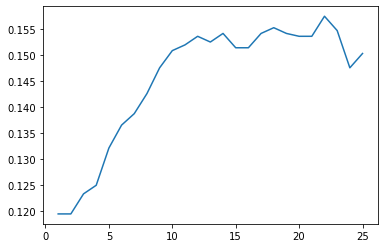

Using custom data configuration default-326223662ac9146d
Reusing dataset csv (/mount/studenten-temp1/users/knupi/.cache/huggingface/csv/default-326223662ac9146d/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58)


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?ba/s]

  0%|          | 0/6 [00:00<?, ?ba/s]

  0%|          | 0/6 [00:00<?, ?ba/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/28708 [00:00<?, ?ex/s]

  0%|          | 0/448 [00:00<?, ?it/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/3631 [00:00<?, ?ex/s]

  0%|          | 0/56 [00:00<?, ?it/s]


Training examples: 28708
Test examples: 3631


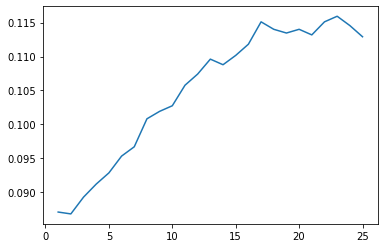

Using custom data configuration default-326223662ac9146d
Reusing dataset csv (/mount/studenten-temp1/users/knupi/.cache/huggingface/csv/default-326223662ac9146d/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58)


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?ba/s]

  0%|          | 0/6 [00:00<?, ?ba/s]

  0%|          | 0/6 [00:00<?, ?ba/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/46120 [00:00<?, ?ex/s]

  0%|          | 0/720 [00:00<?, ?it/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/5764 [00:00<?, ?ex/s]

  0%|          | 0/90 [00:00<?, ?it/s]


Training examples: 46120
Test examples: 5764


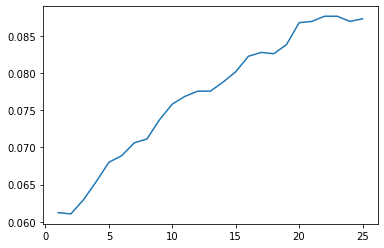

In [12]:
dataset_folder = '../data/'
class_subsets = [10, 20, 50, 100, 200, 400, 642]

results_file = '../results.csv'
for subset in class_subsets:
    dataset, artists = get_dataset(dataset_folder, subset)

    model_name = "bert-base-uncased"
    n, results = run_knn_experiment(model_name, artists, dataset)

    write_pre_bert_results(results_file, results, artists, dataset)

Run experiments that also test the models performance on class size of 300 and 500.

Using custom data configuration default-326223662ac9146d
Reusing dataset csv (/mount/studenten-temp1/users/knupi/.cache/huggingface/csv/default-326223662ac9146d/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58)


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?ba/s]

  0%|          | 0/6 [00:00<?, ?ba/s]

  0%|          | 0/6 [00:00<?, ?ba/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Parameter 'function'=<function transform at 0x7f5e18283400> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a rand

  0%|          | 0/21549 [00:00<?, ?ex/s]

  0%|          | 0/336 [00:00<?, ?it/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/2688 [00:00<?, ?ex/s]

  0%|          | 0/42 [00:00<?, ?it/s]


Training examples: 21549
Test examples: 2688


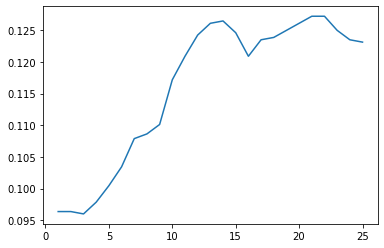

Using custom data configuration default-326223662ac9146d
Reusing dataset csv (/mount/studenten-temp1/users/knupi/.cache/huggingface/csv/default-326223662ac9146d/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58)


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?ba/s]

  0%|          | 0/6 [00:00<?, ?ba/s]

  0%|          | 0/6 [00:00<?, ?ba/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/36306 [00:00<?, ?ex/s]

  0%|          | 0/567 [00:00<?, ?it/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/4560 [00:00<?, ?ex/s]

  0%|          | 0/71 [00:00<?, ?it/s]


Training examples: 36306
Test examples: 4560


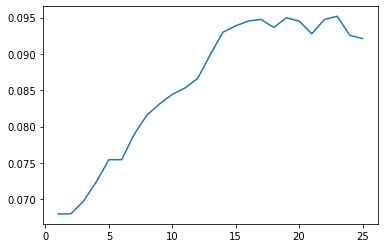

In [6]:
dataset_folder = '../data/'
class_subsets = [300, 500]

results_file = '../results.csv'
for subset in class_subsets:
    dataset, artists = get_dataset(dataset_folder, subset)

    model_name = "bert-base-uncased"
    n, results = run_knn_experiment(model_name, artists, dataset)

    write_pre_bert_results(results_file, results, artists, dataset)

## Fine-tune BERT on artist classification
Now we're going to fine-tune the BERT model on SequenceClassification task, using the classic pipelines

In [6]:
from datasets import load_dataset, ClassLabel


def get_dataset(dataset_folder, subclass_size):
   dataset = load_dataset('csv',
                        data_files={
                           'train': dataset_folder + 'songs_train.txt',
                           'test': dataset_folder + 'songs_test.txt',
                           'dev': dataset_folder + 'songs_dev.txt',
                        },
                        column_names=['artist', 'title', 'lyrics'],
                        sep='\t')

   # the last one takes it all
   if subclass_size != 643:
      set_artist = list(set(dataset['train']['artist']))[:subclass_size]
      dataset = dataset.filter(lambda x: x['artist'] in set_artist)

   union_artists = set(dataset['train']['artist']) | set(dataset['test']['artist']) | set(dataset['dev']['artist'])
   artists = ClassLabel(names=list(union_artists))

   return dataset, artists


In [7]:

from transformers import AutoTokenizer, AutoModelForSequenceClassification 
from datasets import set_caching_enabled

import torch

def run_bert_experiment(artists, dataset):
    # but for now I'm only gonna use bert, cuz RAM
    model_name = "bert-base-uncased"

    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(model_name,
                                                            num_labels=artists.num_classes,
                                                            problem_type="single_label_classification"
                                                            )

    #################
    # ==== BERT ====
    #################
    # Turn labels to numbers and tokenize input
    def transform(batch):
        batch['labels'] = artists.str2int(batch['artist'])
        return tokenizer(batch["lyrics"], padding="max_length", truncation=True)


    set_caching_enabled(False)
    tokenized_datasets = dataset.map(transform, batched=True, load_from_cache_file=False).remove_columns(['artist', 'title', 'lyrics'])

    print(tokenized_datasets)
    set_caching_enabled(True)

    import evaluate
    import numpy as np

    def compute_metrics(eval_preds):
        f1_metric = evaluate.load("f1")
        acc_metric = evaluate.load("accuracy")
        
        logits, labels = eval_preds
        predictions = np.argmax(logits, axis=-1)

        metric = acc_metric.compute(predictions=predictions, references=labels)
        metric.update(f1_metric.compute(predictions=predictions, references=labels, average="micro"))

        return metric

    from transformers import TrainingArguments, Trainer, EarlyStoppingCallback

    training_args = TrainingArguments(
        output_dir="/mount/studenten-temp1/users/knupleun/artist-classification/models/bert-" + str(artists.num_classes),
        evaluation_strategy="steps",
        gradient_checkpointing=True,
        eval_steps=25,
        save_total_limit = 2,
        load_best_model_at_end=True,
        metric_for_best_model = 'f1',
        per_device_train_batch_size=32,  # batch size per device during training
        per_device_eval_batch_size=16,   # batch size for evaluation
        num_train_epochs=10,
        weight_decay=0.01,               # strength of weight decay
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_datasets['train'],
        eval_dataset=tokenized_datasets['dev'],
        compute_metrics=compute_metrics,
        callbacks = [EarlyStoppingCallback(early_stopping_patience=3)]
    )

    trainer.train()
    trainer.save_model()

    results = trainer.evaluate(tokenized_datasets['test'])

    return results

In [8]:
from csv import writer

def write_results(filepath, values):
    with open(filepath, 'a+', newline='') as f:
        csv_writer = writer(f)
        csv_writer.writerow(values)

def write_pre_bert_results(filepath, results, dataset, artists):
    model = "pre-bert"
    class_size = artists.num_classes
    train_size = len(dataset['train'])
    test_size = len(dataset['test'])
    acc = results['eval_accuracy']
    knn = 0

    values = [model, class_size, train_size, test_size, acc, knn]
    write_results(filepath, values)

def write_bert_results(filepath, results, dataset, artists):
    model = "bert"
    class_size = artists.num_classes
    train_size = len(dataset['train'])
    test_size = len(dataset['test'])
    acc = results['eval_accuracy']
    knn = 0

    values = [model, class_size, train_size, test_size, acc, knn]
    write_results(filepath, values)


def write_knn_results(filepath, scores, dataset, artists):
    model = "bert-knn"
    class_size = artists.num_classes
    train_size = len(dataset['train'])
    test_size = len(dataset['test'])

    for n, score in enumerate(scores, start=1):
        values = [model, class_size, train_size, test_size, score, n]
        write_results(filepath, values)

In [17]:
dataset_folder = '../data/'
class_subsets = [10, 20, 50, 100, 200, 400, 642]

results_file = '../results.csv'
for subset in class_subsets:
    dataset, artists = get_dataset(dataset_folder, subset)

    results = run_bert_experiment(artists, dataset)

    write_bert_results(results_file, results, dataset, artists)

Using custom data configuration default-326223662ac9146d
Reusing dataset csv (/mount/studenten-temp1/users/knupi/.cache/huggingface/csv/default-326223662ac9146d/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached processed dataset at /mount/studenten-temp1/users/knupi/.cache/huggingface/csv/default-326223662ac9146d/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58/cache-b5575c20b2b67aa1.arrow
Loading cached processed dataset at /mount/studenten-temp1/users/knupi/.cache/huggingface/csv/default-326223662ac9146d/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58/cache-816281e95d383136.arrow
Loading cached processed dataset at /mount/studenten-temp1/users/knupi/.cache/huggingface/csv/default-326223662ac9146d/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58/cache-f662dad844d67f43.arrow
loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /mount/studenten-temp1/users/knupleun/.cache/huggingface/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "_name_or_path": "ber

  0%|          | 0/4 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running training *****
  Num examples = 3628
  Num Epochs = 10
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 1140


DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 3628
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 465
    })
    dev: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 446
    })
})


Step,Training Loss,Validation Loss,Accuracy,F1
25,No log,3.707354,0.058296,0.058296
50,No log,3.616534,0.047085,0.047085
75,No log,3.514347,0.112108,0.112108
100,No log,3.441247,0.096413,0.096413
125,No log,3.317100,0.159193,0.159193
150,No log,3.306845,0.143498,0.143498
175,No log,3.132953,0.199552,0.199552
200,No log,2.993761,0.242152,0.242152
225,No log,2.899408,0.257848,0.257848
250,No log,2.833225,0.284753,0.284753


***** Running Evaluation *****
  Num examples = 446
  Batch size = 16
***** Running Evaluation *****
  Num examples = 446
  Batch size = 16
***** Running Evaluation *****
  Num examples = 446
  Batch size = 16
***** Running Evaluation *****
  Num examples = 446
  Batch size = 16
***** Running Evaluation *****
  Num examples = 446
  Batch size = 16
***** Running Evaluation *****
  Num examples = 446
  Batch size = 16
***** Running Evaluation *****
  Num examples = 446
  Batch size = 16
***** Running Evaluation *****
  Num examples = 446
  Batch size = 16
***** Running Evaluation *****
  Num examples = 446
  Batch size = 16
***** Running Evaluation *****
  Num examples = 446
  Batch size = 16
***** Running Evaluation *****
  Num examples = 446
  Batch size = 16
***** Running Evaluation *****
  Num examples = 446
  Batch size = 16
***** Running Evaluation *****
  Num examples = 446
  Batch size = 16
***** Running Evaluation *****
  Num examples = 446
  Batch size = 16
***** Running Evalua

Using custom data configuration default-326223662ac9146d
Reusing dataset csv (/mount/studenten-temp1/users/knupi/.cache/huggingface/csv/default-326223662ac9146d/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached processed dataset at /mount/studenten-temp1/users/knupi/.cache/huggingface/csv/default-326223662ac9146d/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58/cache-3b8beef4082778ba.arrow
Loading cached processed dataset at /mount/studenten-temp1/users/knupi/.cache/huggingface/csv/default-326223662ac9146d/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58/cache-2188a0442942bfbe.arrow
Loading cached processed dataset at /mount/studenten-temp1/users/knupi/.cache/huggingface/csv/default-326223662ac9146d/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58/cache-333206d0ef00d780.arrow
loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /mount/studenten-temp1/users/knupleun/.cache/huggingface/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "_name_or_path": "ber

  0%|          | 0/7 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
/home/users1/knupleun/.local/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 6776
  Num Epochs = 10
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 2120


DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 6776
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 837
    })
    dev: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 828
    })
})


Step,Training Loss,Validation Loss,Accuracy,F1
25,No log,4.493178,0.015700,0.015700
50,No log,4.416796,0.016908,0.016908
75,No log,4.381055,0.032609,0.032609
100,No log,4.329261,0.022947,0.022947
125,No log,4.261973,0.048309,0.048309
150,No log,4.167984,0.085749,0.085749
175,No log,4.102594,0.086957,0.086957
200,No log,4.043418,0.100242,0.100242
225,No log,3.971138,0.109903,0.109903
250,No log,3.859160,0.130435,0.130435


***** Running Evaluation *****
  Num examples = 828
  Batch size = 16
***** Running Evaluation *****
  Num examples = 828
  Batch size = 16
***** Running Evaluation *****
  Num examples = 828
  Batch size = 16
***** Running Evaluation *****
  Num examples = 828
  Batch size = 16
***** Running Evaluation *****
  Num examples = 828
  Batch size = 16
***** Running Evaluation *****
  Num examples = 828
  Batch size = 16
***** Running Evaluation *****
  Num examples = 828
  Batch size = 16
***** Running Evaluation *****
  Num examples = 828
  Batch size = 16
***** Running Evaluation *****
  Num examples = 828
  Batch size = 16
***** Running Evaluation *****
  Num examples = 828
  Batch size = 16
***** Running Evaluation *****
  Num examples = 828
  Batch size = 16
***** Running Evaluation *****
  Num examples = 828
  Batch size = 16
***** Running Evaluation *****
  Num examples = 828
  Batch size = 16
***** Running Evaluation *****
  Num examples = 828
  Batch size = 16
***** Running Evalua

Using custom data configuration default-326223662ac9146d
Reusing dataset csv (/mount/studenten-temp1/users/knupi/.cache/huggingface/csv/default-326223662ac9146d/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached processed dataset at /mount/studenten-temp1/users/knupi/.cache/huggingface/csv/default-326223662ac9146d/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58/cache-5713b749ef061dcf.arrow
Loading cached processed dataset at /mount/studenten-temp1/users/knupi/.cache/huggingface/csv/default-326223662ac9146d/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58/cache-45882ee725f4738d.arrow
Loading cached processed dataset at /mount/studenten-temp1/users/knupi/.cache/huggingface/csv/default-326223662ac9146d/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58/cache-0210d7632bc5406e.arrow
loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /mount/studenten-temp1/users/knupleun/.cache/huggingface/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "_name_or_path": "ber

  0%|          | 0/14 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
/home/users1/knupleun/.local/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 13676
  Num Epochs = 10
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 4280


DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 13676
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1656
    })
    dev: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1709
    })
})


Step,Training Loss,Validation Loss,Accuracy,F1
25,No log,5.256321,0.005266,0.005266
50,No log,5.196747,0.010532,0.010532
75,No log,5.143627,0.010532,0.010532
100,No log,5.125608,0.009947,0.009947
125,No log,5.098784,0.015214,0.015214
150,No log,5.075015,0.016969,0.016969
175,No log,5.046738,0.016969,0.016969
200,No log,5.030194,0.021650,0.021650
225,No log,4.990882,0.018724,0.018724
250,No log,4.921071,0.031012,0.031012


***** Running Evaluation *****
  Num examples = 1709
  Batch size = 16
***** Running Evaluation *****
  Num examples = 1709
  Batch size = 16
***** Running Evaluation *****
  Num examples = 1709
  Batch size = 16
***** Running Evaluation *****
  Num examples = 1709
  Batch size = 16
***** Running Evaluation *****
  Num examples = 1709
  Batch size = 16
***** Running Evaluation *****
  Num examples = 1709
  Batch size = 16
***** Running Evaluation *****
  Num examples = 1709
  Batch size = 16
***** Running Evaluation *****
  Num examples = 1709
  Batch size = 16
***** Running Evaluation *****
  Num examples = 1709
  Batch size = 16
***** Running Evaluation *****
  Num examples = 1709
  Batch size = 16
***** Running Evaluation *****
  Num examples = 1709
  Batch size = 16
***** Running Evaluation *****
  Num examples = 1709
  Batch size = 16
***** Running Evaluation *****
  Num examples = 1709
  Batch size = 16
***** Running Evaluation *****
  Num examples = 1709
  Batch size = 16
***** 

Using custom data configuration default-326223662ac9146d
Reusing dataset csv (/mount/studenten-temp1/users/knupi/.cache/huggingface/csv/default-326223662ac9146d/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached processed dataset at /mount/studenten-temp1/users/knupi/.cache/huggingface/csv/default-326223662ac9146d/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58/cache-a6f4339c5db7a94b.arrow
Loading cached processed dataset at /mount/studenten-temp1/users/knupi/.cache/huggingface/csv/default-326223662ac9146d/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58/cache-e8c86a4a0a48f1b2.arrow
Loading cached processed dataset at /mount/studenten-temp1/users/knupi/.cache/huggingface/csv/default-326223662ac9146d/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58/cache-29f85f12698be446.arrow
loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /mount/studenten-temp1/users/knupleun/.cache/huggingface/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "_name_or_path": "ber

  0%|          | 0/29 [00:00<?, ?ba/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
/home/users1/knupleun/.local/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 28168
  Num Epochs = 10
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 8810


DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 28168
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 3458
    })
    dev: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 3513
    })
})


Step,Training Loss,Validation Loss,Accuracy,F1
25,No log,5.975294,0.002562,0.002562
50,No log,5.945628,0.003131,0.003131
75,No log,5.903123,0.005693,0.005693
100,No log,5.867774,0.004555,0.004555
125,No log,5.858038,0.004555,0.004555
150,No log,5.847834,0.004555,0.004555
175,No log,5.839683,0.004555,0.004555
200,No log,5.835363,0.005408,0.005408
225,No log,5.831588,0.005408,0.005408
250,No log,5.832841,0.001993,0.001993


***** Running Evaluation *****
  Num examples = 3513
  Batch size = 16
***** Running Evaluation *****
  Num examples = 3513
  Batch size = 16
***** Running Evaluation *****
  Num examples = 3513
  Batch size = 16
***** Running Evaluation *****
  Num examples = 3513
  Batch size = 16
***** Running Evaluation *****
  Num examples = 3513
  Batch size = 16
***** Running Evaluation *****
  Num examples = 3513
  Batch size = 16
***** Running Evaluation *****
  Num examples = 3513
  Batch size = 16
***** Running Evaluation *****
  Num examples = 3513
  Batch size = 16
***** Running Evaluation *****
  Num examples = 3513
  Batch size = 16
***** Running Evaluation *****
  Num examples = 3513
  Batch size = 16
***** Running Evaluation *****
  Num examples = 3513
  Batch size = 16
***** Running Evaluation *****
  Num examples = 3513
  Batch size = 16
***** Running Evaluation *****
  Num examples = 3513
  Batch size = 16
***** Running Evaluation *****
  Num examples = 3513
  Batch size = 16
***** 

Using custom data configuration default-326223662ac9146d
Reusing dataset csv (/mount/studenten-temp1/users/knupi/.cache/huggingface/csv/default-326223662ac9146d/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58)


  0%|          | 0/3 [00:00<?, ?it/s]

loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /mount/studenten-temp1/users/knupleun/.cache/huggingface/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.20.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading file https://huggingface.co/bert-base

  0%|          | 0/47 [00:00<?, ?ba/s]

  0%|          | 0/6 [00:00<?, ?ba/s]

  0%|          | 0/6 [00:00<?, ?ba/s]

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 46120
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 5765
    })
    dev: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 5765
    })
})


/home/users1/knupleun/.local/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 46120
  Num Epochs = 10
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 14420


Step,Training Loss,Validation Loss,Accuracy,F1
25,No log,6.468728,0.002428,0.002428
50,No log,6.435289,0.002949,0.002949
75,No log,6.389791,0.003296,0.003296
100,No log,6.369172,0.003296,0.003296
125,No log,6.367560,0.002949,0.002949
150,No log,6.357754,0.001735,0.001735
175,No log,6.340153,0.002428,0.002428
200,No log,6.325827,0.002775,0.002775
225,No log,6.324964,0.002082,0.002082
250,No log,6.304521,0.002428,0.002428


***** Running Evaluation *****
  Num examples = 5765
  Batch size = 16
***** Running Evaluation *****
  Num examples = 5765
  Batch size = 16
***** Running Evaluation *****
  Num examples = 5765
  Batch size = 16
***** Running Evaluation *****
  Num examples = 5765
  Batch size = 16
***** Running Evaluation *****
  Num examples = 5765
  Batch size = 16
***** Running Evaluation *****
  Num examples = 5765
  Batch size = 16
***** Running Evaluation *****
  Num examples = 5765
  Batch size = 16
***** Running Evaluation *****
  Num examples = 5765
  Batch size = 16
***** Running Evaluation *****
  Num examples = 5765
  Batch size = 16
***** Running Evaluation *****
  Num examples = 5765
  Batch size = 16
***** Running Evaluation *****
  Num examples = 5765
  Batch size = 16
***** Running Evaluation *****
  Num examples = 5765
  Batch size = 16
***** Running Evaluation *****
  Num examples = 5765
  Batch size = 16
***** Running Evaluation *****
  Num examples = 5765
  Batch size = 16
***** 

In [9]:
#################
# ==== kNN ====
#################

from tqdm.notebook import tqdm
from transformers import AutoModel
import torch

def transform(example):
    example['lyrics'] = example['lyrics'].replace(' NEWLINE ', ' [SEP] ')

    return example

def get_embeddings(model_path, artists, dataset):
    model = AutoModel.from_pretrained(model_path, output_hidden_states=True).to('cuda')
    tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

    tokenized_dataset = dataset.map(transform, load_from_cache_file=False)

    batch_size = 64
    num_shards = len(tokenized_dataset) // batch_size 
    embeddings = []
    labels = []
    for i in tqdm(range(num_shards)):
        shard = tokenized_dataset.shard(num_shards=num_shards, index=i)
        model_inputs = tokenizer(shard['lyrics'], padding=True, truncation=True, return_tensors="pt").to('cuda')

        labels.extend(artists.str2int(shard['artist']))

        # Info on getting hidden state embeddings
        # https://mccormickml.com/2019/05/14/BERT-word-embeddings-tutorial/#32-understanding-the-output
        with torch.no_grad():
            outputs = model(**model_inputs)

            hidden_states = outputs[2]

            # Getting single vector representations by averaging the second to last hiden layer of each token producing a single 768 length vector.
            token_vecs = hidden_states[-2]


            # Calculate the average of all 512 token vectors (that's the size of the input)
            # Using the second dimension, because the first representes each lyric
            sentence_embedding = torch.mean(token_vecs, dim=1)
            sentence_embedding = sentence_embedding.cpu().detach().numpy()

            embeddings.extend(sentence_embedding)


    del model
    del tokenizer 

    torch.cuda.empty_cache()
    return embeddings, labels

def run_knn_experiment(model_path, artists, dataset):
    from sklearn.neighbors import KNeighborsClassifier

    train_embeddings, train_labels = get_embeddings(model_path, artists, dataset['train'])
    test_embeddings, test_labels = get_embeddings(model_path, artists, dataset['test'])

    neigh = KNeighborsClassifier(weights="distance")
    neigh.fit(train_embeddings, train_labels)


    import matplotlib.pyplot as plt
    import evaluate

    acc_metric = evaluate.load("accuracy")

    def evalute_knn(embeddings, references):
        diff_setups = []
        for n in range(1,26):
            neigh.set_params(n_neighbors=n)
            predictions = neigh.predict(embeddings)

            diff_setups.append({'n': n, 'predictions': predictions})

        scores = []
        n_neighbours = []
        for i, setup in enumerate(diff_setups):
            metric = acc_metric.compute(predictions=setup['predictions'], references=references)

            score = metric['accuracy']
            scores.append(score)
            n_neighbours.append(i + 1)

        return n_neighbours, scores


    n_neighbours, scores = evalute_knn(test_embeddings, test_labels)

    plt.plot(n_neighbours, scores)

    print()
    print('Training examples:', len(train_embeddings))
    print('Test examples:', len(test_embeddings))
    plt.show()

    torch.cuda.empty_cache()

    return n_neighbours, scores

Using custom data configuration default-326223662ac9146d
Reusing dataset csv (/mount/studenten-temp1/users/knupi/.cache/huggingface/csv/default-326223662ac9146d/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached processed dataset at /mount/studenten-temp1/users/knupi/.cache/huggingface/csv/default-326223662ac9146d/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58/cache-fe1d92e42689c93a.arrow
Loading cached processed dataset at /mount/studenten-temp1/users/knupi/.cache/huggingface/csv/default-326223662ac9146d/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58/cache-f4be0b13fbefb833.arrow
Loading cached processed dataset at /mount/studenten-temp1/users/knupi/.cache/huggingface/csv/default-326223662ac9146d/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58/cache-51c951e8f43d925d.arrow
Some weights of the model checkpoint at ../models/bert-10/ were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a

  0%|          | 0/657 [00:00<?, ?ex/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Some weights of the model checkpoint at ../models/bert-10/ were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/83 [00:00<?, ?ex/s]

  0%|          | 0/1 [00:00<?, ?it/s]


Training examples: 657
Test examples: 83


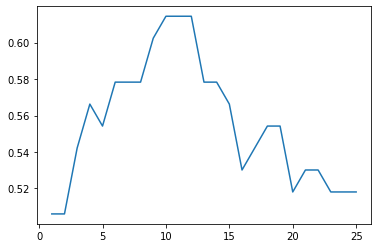

Using custom data configuration default-326223662ac9146d
Reusing dataset csv (/mount/studenten-temp1/users/knupi/.cache/huggingface/csv/default-326223662ac9146d/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached processed dataset at /mount/studenten-temp1/users/knupi/.cache/huggingface/csv/default-326223662ac9146d/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58/cache-c94e11b00638522b.arrow
Loading cached processed dataset at /mount/studenten-temp1/users/knupi/.cache/huggingface/csv/default-326223662ac9146d/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58/cache-8854d2a8022a2511.arrow
Loading cached processed dataset at /mount/studenten-temp1/users/knupi/.cache/huggingface/csv/default-326223662ac9146d/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58/cache-fbd266e8e1244cbb.arrow
Some weights of the model checkpoint at ../models/bert-20/ were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a

  0%|          | 0/1298 [00:00<?, ?ex/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Some weights of the model checkpoint at ../models/bert-20/ were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/168 [00:00<?, ?ex/s]

  0%|          | 0/2 [00:00<?, ?it/s]


Training examples: 1298
Test examples: 168


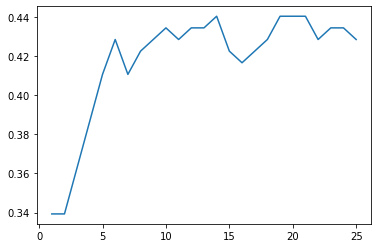

Using custom data configuration default-326223662ac9146d
Reusing dataset csv (/mount/studenten-temp1/users/knupi/.cache/huggingface/csv/default-326223662ac9146d/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached processed dataset at /mount/studenten-temp1/users/knupi/.cache/huggingface/csv/default-326223662ac9146d/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58/cache-3711c0cb0ca17cc5.arrow
Loading cached processed dataset at /mount/studenten-temp1/users/knupi/.cache/huggingface/csv/default-326223662ac9146d/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58/cache-e2098fad4ac2fb9f.arrow
Loading cached processed dataset at /mount/studenten-temp1/users/knupi/.cache/huggingface/csv/default-326223662ac9146d/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58/cache-6fbc8ecd1cb6cb08.arrow
Some weights of the model checkpoint at ../models/bert-50/ were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a

  0%|          | 0/3751 [00:00<?, ?ex/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Some weights of the model checkpoint at ../models/bert-50/ were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/440 [00:00<?, ?ex/s]

  0%|          | 0/6 [00:00<?, ?it/s]


Training examples: 3751
Test examples: 440


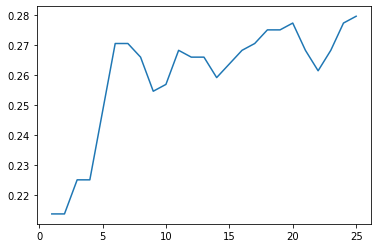

Using custom data configuration default-326223662ac9146d
Reusing dataset csv (/mount/studenten-temp1/users/knupi/.cache/huggingface/csv/default-326223662ac9146d/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached processed dataset at /mount/studenten-temp1/users/knupi/.cache/huggingface/csv/default-326223662ac9146d/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58/cache-7a80d14753f271d7.arrow
Loading cached processed dataset at /mount/studenten-temp1/users/knupi/.cache/huggingface/csv/default-326223662ac9146d/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58/cache-b6d88e22e3be6349.arrow
Loading cached processed dataset at /mount/studenten-temp1/users/knupi/.cache/huggingface/csv/default-326223662ac9146d/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58/cache-f87ff85dd9ca033a.arrow
Some weights of the model checkpoint at ../models/bert-100/ were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from 

  0%|          | 0/7236 [00:00<?, ?ex/s]

  0%|          | 0/113 [00:00<?, ?it/s]

Some weights of the model checkpoint at ../models/bert-100/ were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/863 [00:00<?, ?ex/s]

  0%|          | 0/13 [00:00<?, ?it/s]


Training examples: 7236
Test examples: 863


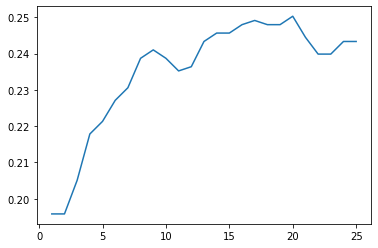

Using custom data configuration default-326223662ac9146d
Reusing dataset csv (/mount/studenten-temp1/users/knupi/.cache/huggingface/csv/default-326223662ac9146d/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached processed dataset at /mount/studenten-temp1/users/knupi/.cache/huggingface/csv/default-326223662ac9146d/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58/cache-84058cc242281cf8.arrow
Loading cached processed dataset at /mount/studenten-temp1/users/knupi/.cache/huggingface/csv/default-326223662ac9146d/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58/cache-36326db3c5245f26.arrow
Loading cached processed dataset at /mount/studenten-temp1/users/knupi/.cache/huggingface/csv/default-326223662ac9146d/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58/cache-551d687df36bcaf1.arrow
Some weights of the model checkpoint at ../models/bert-200/ were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from 

  0%|          | 0/14635 [00:00<?, ?ex/s]

  0%|          | 0/228 [00:00<?, ?it/s]

Some weights of the model checkpoint at ../models/bert-200/ were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/1819 [00:00<?, ?ex/s]

  0%|          | 0/28 [00:00<?, ?it/s]


Training examples: 14635
Test examples: 1819


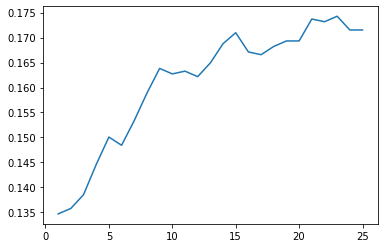

Using custom data configuration default-326223662ac9146d
Reusing dataset csv (/mount/studenten-temp1/users/knupi/.cache/huggingface/csv/default-326223662ac9146d/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58)


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?ba/s]

  0%|          | 0/6 [00:00<?, ?ba/s]

  0%|          | 0/6 [00:00<?, ?ba/s]

Some weights of the model checkpoint at ../models/bert-400/ were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/29188 [00:00<?, ?ex/s]

  0%|          | 0/456 [00:00<?, ?it/s]

Some weights of the model checkpoint at ../models/bert-400/ were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/3586 [00:00<?, ?ex/s]

  0%|          | 0/56 [00:00<?, ?it/s]


Training examples: 29188
Test examples: 3586


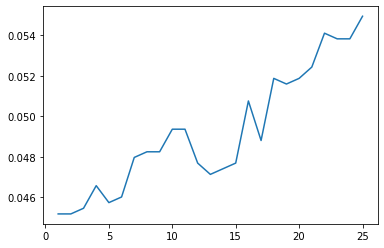

Using custom data configuration default-326223662ac9146d
Reusing dataset csv (/mount/studenten-temp1/users/knupi/.cache/huggingface/csv/default-326223662ac9146d/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58)


  0%|          | 0/3 [00:00<?, ?it/s]

OSError: We couldn't connect to 'https://huggingface.co' to load this model, couldn't find it in the cached files and it looks like ../models/bert-642/ is not the path to a directory containing a config.json file.
Checkout your internet connection or see how to run the library in offline mode at 'https://huggingface.co/docs/transformers/installation#offline-mode'.

In [77]:
dataset_folder = '../data/'
class_subsets = [10, 20, 50, 100, 200, 400, 642]

results_file = '../results.csv'
for subset in class_subsets:
    dataset, artists = get_dataset(dataset_folder, subset)

    model_path = '../models/bert-' + str(subset) + '/'
    n, results = run_knn_experiment(model_path, artists, dataset)

    write_knn_results(results_file, results, dataset, artists)

Using custom data configuration default-326223662ac9146d
Reusing dataset csv (/mount/studenten-temp1/users/knupi/.cache/huggingface/csv/default-326223662ac9146d/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58)


  0%|          | 0/3 [00:00<?, ?it/s]

Some weights of the model checkpoint at ../models/bert-643/ were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/46120 [00:00<?, ?ex/s]

  0%|          | 0/720 [00:00<?, ?it/s]

Some weights of the model checkpoint at ../models/bert-643/ were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/5765 [00:00<?, ?ex/s]

  0%|          | 0/90 [00:00<?, ?it/s]


Training examples: 46120
Test examples: 5765


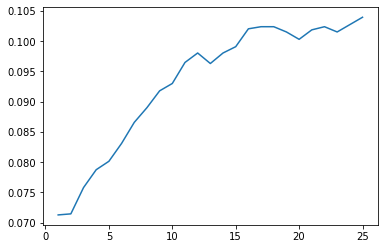

In [79]:
dataset_folder = '../data/'
class_subsets = [643]

results_file = '../results.csv'
for subset in class_subsets:
    dataset, artists = get_dataset(dataset_folder, subset)

    model_path = '../models/bert-' + str(subset) + '/'
    n, results = run_knn_experiment(model_path, artists, dataset)

    write_knn_results(results_file, results, dataset, artists)

Run experiments that also test the models performance on class size of 300 and 500.

Again we'll first fine-tune the model to classify the artists using a classification head.

In [10]:
dataset_folder = '../data/'
class_subsets = [300, 500]

results_file = '../results.csv'
for subset in class_subsets:
    dataset, artists = get_dataset(dataset_folder, subset)

    results = run_bert_experiment(artists, dataset)

    write_bert_results(results_file, results, dataset, artists)

Using custom data configuration default-326223662ac9146d
Reusing dataset csv (/mount/studenten-temp1/users/knupi/.cache/huggingface/csv/default-326223662ac9146d/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58)


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?ba/s]

  0%|          | 0/6 [00:00<?, ?ba/s]

  0%|          | 0/6 [00:00<?, ?ba/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

  0%|          | 0/21 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 20948
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2645
    })
    dev: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2564
    })
})


/home/users1/knupleun/.local/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 20948
  Num Epochs = 10
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 6550


Step,Training Loss,Validation Loss,Accuracy,F1
25,No log,5.684210,0.008580,0.008580
50,No log,5.643255,0.007020,0.007020
75,No log,5.601023,0.005460,0.005460
100,No log,5.580158,0.007020,0.007020
125,No log,5.550696,0.006240,0.006240
150,No log,5.526859,0.006240,0.006240
175,No log,5.525939,0.005460,0.005460
200,No log,5.478463,0.010140,0.010140
225,No log,5.457202,0.014821,0.014821
250,No log,5.451024,0.017941,0.017941


***** Running Evaluation *****
  Num examples = 2564
  Batch size = 16
***** Running Evaluation *****
  Num examples = 2564
  Batch size = 16
***** Running Evaluation *****
  Num examples = 2564
  Batch size = 16
***** Running Evaluation *****
  Num examples = 2564
  Batch size = 16
***** Running Evaluation *****
  Num examples = 2564
  Batch size = 16
***** Running Evaluation *****
  Num examples = 2564
  Batch size = 16
***** Running Evaluation *****
  Num examples = 2564
  Batch size = 16
***** Running Evaluation *****
  Num examples = 2564
  Batch size = 16
***** Running Evaluation *****
  Num examples = 2564
  Batch size = 16
***** Running Evaluation *****
  Num examples = 2564
  Batch size = 16
***** Running Evaluation *****
  Num examples = 2564
  Batch size = 16
***** Running Evaluation *****
  Num examples = 2564
  Batch size = 16
***** Running Evaluation *****
  Num examples = 2564
  Batch size = 16
***** Running Evaluation *****
  Num examples = 2564
  Batch size = 16
***** 

Using custom data configuration default-326223662ac9146d
Reusing dataset csv (/mount/studenten-temp1/users/knupi/.cache/huggingface/csv/default-326223662ac9146d/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58)


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?ba/s]

  0%|          | 0/6 [00:00<?, ?ba/s]

  0%|          | 0/6 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /mount/studenten-temp1/users/knupleun/.cache/huggingface/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.17.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading file https://huggingface.co/bert-base

  0%|          | 0/36 [00:00<?, ?ba/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 35813
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 4535
    })
    dev: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 4474
    })
})


/home/users1/knupleun/.local/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 35813
  Num Epochs = 10
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 11200


Step,Training Loss,Validation Loss,Accuracy,F1
25,No log,6.209684,0.002459,0.002459
50,No log,6.176532,0.001341,0.001341
75,No log,6.147694,0.003800,0.003800
100,No log,6.122943,0.003800,0.003800
125,No log,6.105020,0.003353,0.003353
150,No log,6.089648,0.003800,0.003800
175,No log,6.087462,0.003353,0.003353
200,No log,6.082290,0.003353,0.003353
225,No log,6.072074,0.003800,0.003800
250,No log,6.061157,0.003800,0.003800


***** Running Evaluation *****
  Num examples = 4474
  Batch size = 16
***** Running Evaluation *****
  Num examples = 4474
  Batch size = 16
***** Running Evaluation *****
  Num examples = 4474
  Batch size = 16
***** Running Evaluation *****
  Num examples = 4474
  Batch size = 16
***** Running Evaluation *****
  Num examples = 4474
  Batch size = 16
***** Running Evaluation *****
  Num examples = 4474
  Batch size = 16
***** Running Evaluation *****
  Num examples = 4474
  Batch size = 16
***** Running Evaluation *****
  Num examples = 4474
  Batch size = 16
***** Running Evaluation *****
  Num examples = 4474
  Batch size = 16
***** Running Evaluation *****
  Num examples = 4474
  Batch size = 16
***** Running Evaluation *****
  Num examples = 4474
  Batch size = 16
***** Running Evaluation *****
  Num examples = 4474
  Batch size = 16
***** Running Evaluation *****
  Num examples = 4474
  Batch size = 16
***** Running Evaluation *****
  Num examples = 4474
  Batch size = 16
***** 

Then we'll continue with using the fine-tuned model embeddings with kNN

Using custom data configuration default-326223662ac9146d
Reusing dataset csv (/mount/studenten-temp1/users/knupi/.cache/huggingface/csv/default-326223662ac9146d/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58)


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?ba/s]

  0%|          | 0/6 [00:00<?, ?ba/s]

  0%|          | 0/6 [00:00<?, ?ba/s]

Some weights of the model checkpoint at ../models/bert-300/ were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Parameter 'function'=<function transform at 0x7f19d282fac0> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the

  0%|          | 0/20743 [00:00<?, ?ex/s]

  0%|          | 0/324 [00:00<?, ?it/s]

Some weights of the model checkpoint at ../models/bert-300/ were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/2616 [00:00<?, ?ex/s]

  0%|          | 0/40 [00:00<?, ?it/s]


Training examples: 20743
Test examples: 2616


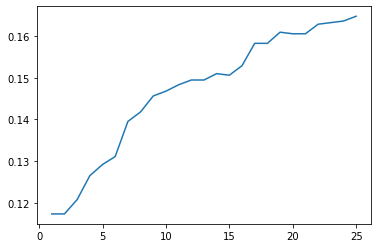

Using custom data configuration default-326223662ac9146d
Reusing dataset csv (/mount/studenten-temp1/users/knupi/.cache/huggingface/csv/default-326223662ac9146d/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58)


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?ba/s]

  0%|          | 0/6 [00:00<?, ?ba/s]

  0%|          | 0/6 [00:00<?, ?ba/s]

Some weights of the model checkpoint at ../models/bert-500/ were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/35555 [00:00<?, ?ex/s]

  0%|          | 0/555 [00:00<?, ?it/s]

Some weights of the model checkpoint at ../models/bert-500/ were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/4503 [00:00<?, ?ex/s]

  0%|          | 0/70 [00:00<?, ?it/s]


Training examples: 35555
Test examples: 4503


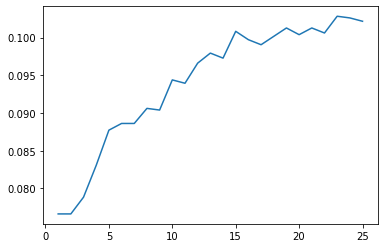

In [10]:
dataset_folder = '../data/'
class_subsets = [300, 500]

results_file = '../results.csv'
for subset in class_subsets:
    dataset, artists = get_dataset(dataset_folder, subset)

    model_path = '../models/bert-' + str(subset) + '/'
    n, results = run_knn_experiment(model_path, artists, dataset)

    write_knn_results(results_file, results, dataset, artists)